In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots
using OrdinaryDiffEq, Interpolations
const ODE = OrdinaryDiffEq

OrdinaryDiffEq

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 100
quadrature_order       = 1
t_initial              = minimum(Time)
t_end                  = t_initial+90
wind_scale             = 1e-5
wind_center            = 30;

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
ctx, _ = regularTriangularGrid((grid_resolution, Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))), 
        LL, UR, quadrature_order = quadrature_order);

In [7]:
function evaluate_on_grid(f,ctx)
    [f(node.x) for node in ctx.grid.nodes]
end

evaluate_on_grid (generic function with 1 method)

In [8]:
function l1_error(reference,solution)
    sum(sum([abs.(a .- b) for (a,b) in zip(reference,solution)])) / (2*length(reference))
end

l1_error (generic function with 1 method)

In [9]:
function l2_error(reference,solution)
    sum(sqrt.(sum([(a .- b).^2 for (a,b) in zip(reference,solution)]))) / (2*length(reference))
end

l2_error (generic function with 1 method)

In [10]:
function linfty_error(reference,solution)
    sum(maximum([(a .- b) for (a,b) in zip(reference,solution)]))
end

linfty_error (generic function with 1 method)

In [11]:
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t));

In [12]:
function T(solver, tolerance)
    return (x, param) -> flow(interp_rhs_scaled, x, [t_initial, t_end]; p=(UV, wind, param),
            tolerance=tolerance,solver=solver)[end]
end

T (generic function with 1 method)

In [13]:
function Tdot_autodiff(solver, tolerance, param)
    return x -> Main.CoherentStructures.parameter_autodiff(T(solver, tolerance), x, param)
end

Tdot_autodiff (generic function with 1 method)

In [14]:
function Tdot_finite_differences(solver, tolerance, param, diff)
    return x -> 
     (T(solver, tolerance)(x, param+diff) .- T(solver, tolerance)(x, param-diff)) ./ (2*diff)
end

Tdot_finite_differences (generic function with 1 method)

In [15]:
variational_equation = OrdinaryDiffEq.ODEFunction{false}(
    (u,p,t) ->  
    vcat(p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t), 
    hcat(p[4](u[1],u[2],t)...) * u[3:4] .+ p[5](u[1],u[2],t))
);

In [16]:
dUV(x,y,t) = Interpolations.gradient(UV,x,y,t)[1:2]
dParam = wind                                        # very handy here

function Tdot_vareq(solver, tolerance, param)
    return x -> 
    flow(variational_equation, vcat(x,0,0), [t_initial, t_end]; 
        p=(UV, wind, param, dUV, dParam), tolerance=tolerance, solver=solver)[end][3:4]
end

Tdot_vareq (generic function with 1 method)

In [17]:
tolerance_range_BS5 = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15];

In [18]:
@time reference_BS5 = evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.BS5(),1e-16,0),ctx);

930.049546 seconds (12.28 G allocations: 427.525 GiB, 7.88% gc time)


In [19]:
@time autodiff_BS5    = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.BS5(),tolerance,0),ctx) 
    for tolerance in tolerance_range_BS5]
@time vareq_BS5 = [evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.BS5(),tolerance,0),ctx) 
    for tolerance in tolerance_range_BS5];
@time FD_1eminus3_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-3),ctx)
    for tolerance in tolerance_range_BS5]
@time FD_1eminus4_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-4),ctx) 
    for tolerance in tolerance_range_BS5]
@time FD_1eminus5_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-5),ctx)
    for tolerance in tolerance_range_BS5];
@time FD_1eminus6_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-6),ctx)
    for tolerance in tolerance_range_BS5];
@time FD_1eminus7_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tolerance,0,1e-7),ctx)
    for tolerance in tolerance_range_BS5];

169.595116 seconds (22.67 M allocations: 1.324 GiB, 0.19% gc time)
867.012079 seconds (11.25 G allocations: 391.288 GiB, 7.78% gc time)
 74.809039 seconds (13.35 M allocations: 1.015 GiB, 0.26% gc time)
 72.657806 seconds (6.25 M allocations: 686.175 MiB, 0.12% gc time)
 73.452342 seconds (6.25 M allocations: 686.175 MiB, 0.17% gc time)
 73.237519 seconds (6.25 M allocations: 686.175 MiB, 0.16% gc time)
 72.776902 seconds (6.25 M allocations: 686.175 MiB, 0.13% gc time)


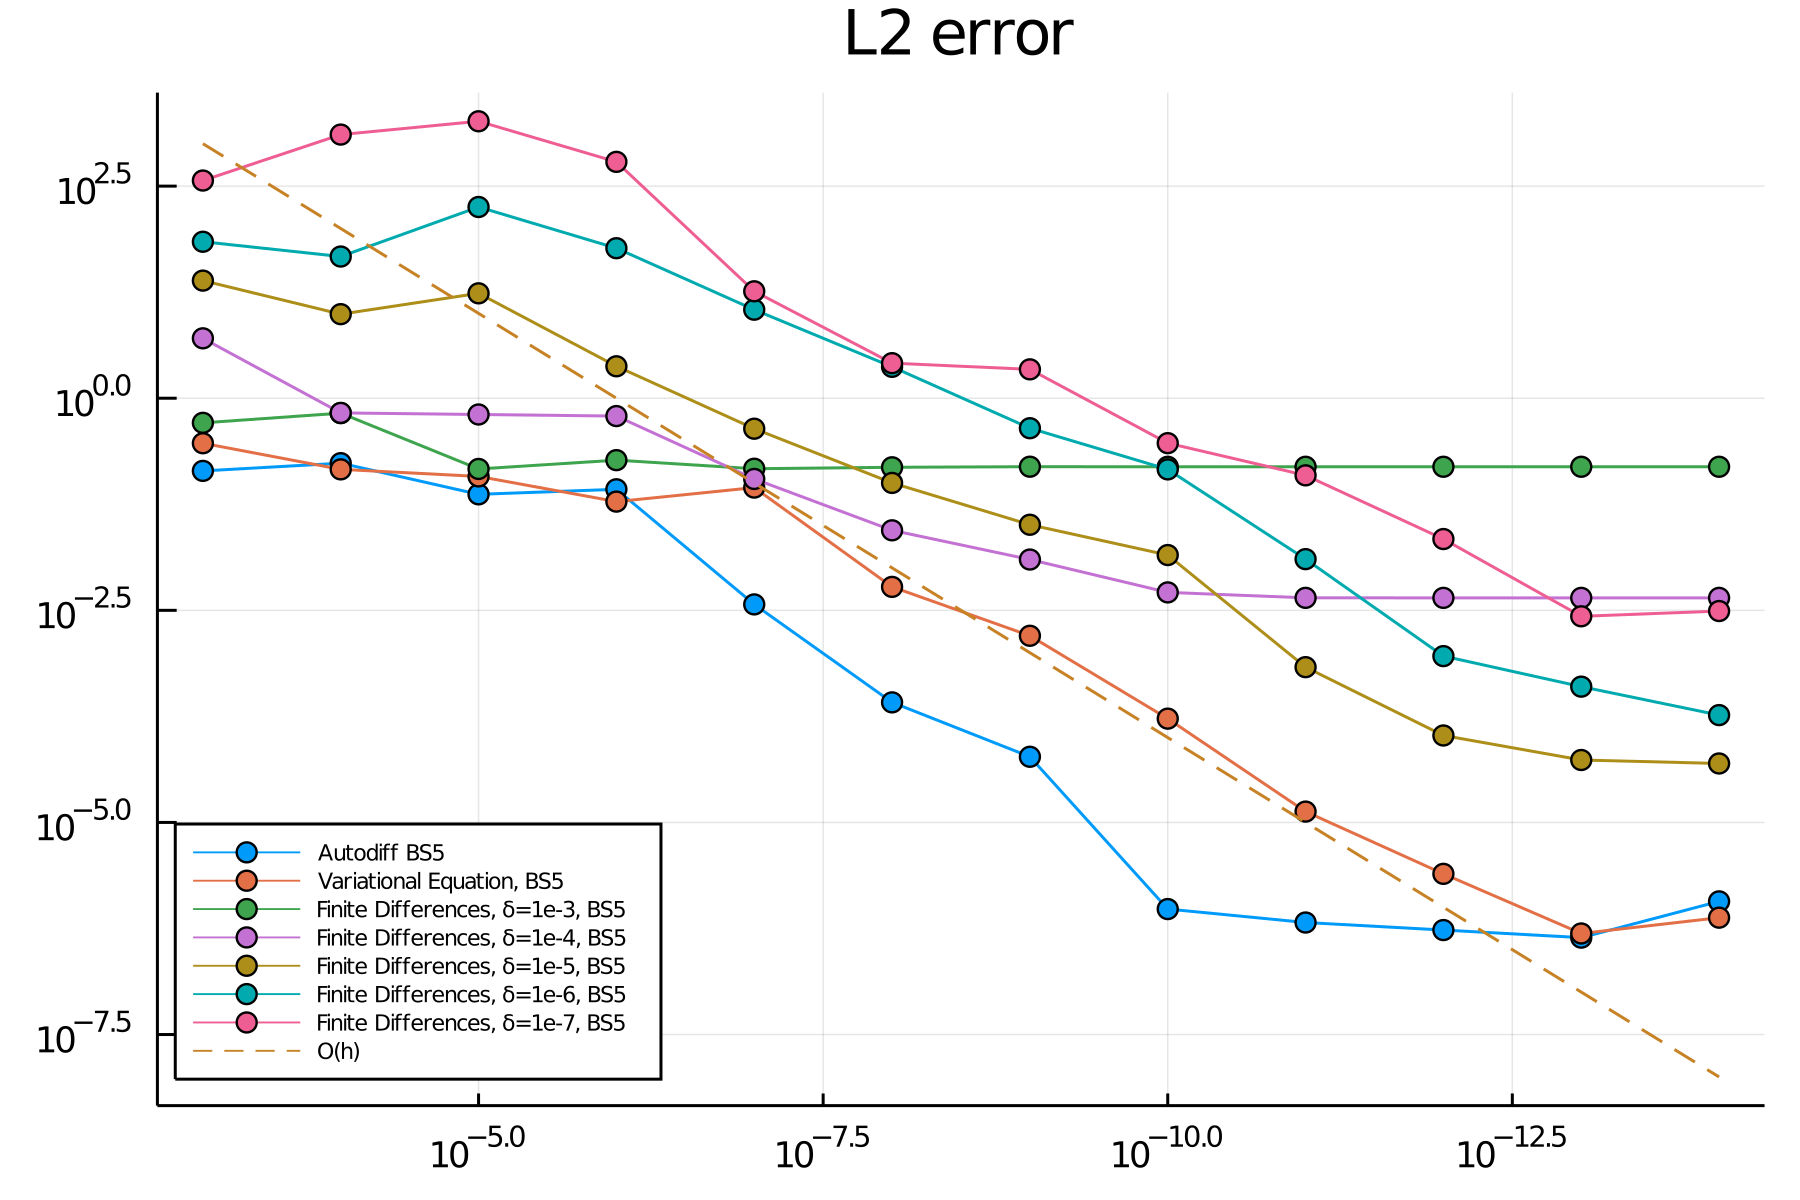

In [35]:
l2_plot_BS5 = Plots.plot(tolerance_range_BS5,[l2_error(reference_BS5,tol) 
        for tol in autodiff_BS5], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff BS5"
    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
Plots.plot!(tolerance_range_BS5,[l2_error(reference_BS5,tol)
        for tol in vareq_BS5], 
    marker=:dot, label="Variational Equation, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(reference_BS5,tol)
         for tol in FD_1eminus3_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-3, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(reference_BS5,tol)
         for tol in FD_1eminus4_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-4, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(reference_BS5,tol)
         for tol in FD_1eminus5_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-5, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(reference_BS5,tol)
         for tol in FD_1eminus6_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-6, BS5")
Plots.plot!(tolerance_range_BS5,[l2_error(reference_BS5,tol)
         for tol in FD_1eminus7_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-7, BS5")
Plots.plot!(tolerance_range_BS5,[1000000x for x in tolerance_range_BS5], 
    linestyle=:dash,label="O(h)")

In [21]:
#tolerance_range_DP8 = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14];

In [22]:
#reference_DP8 = evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.DP8(),1e-16,0),ctx);

In [23]:
#autodiff_DP8     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.DP8(),tolerance,0),ctx) 
#    for tolerance in tolerance_range_DP8]
#vareq_DP8 = [evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.DP8(),tolerance,0),ctx) 
#    for tolerance in tolerance_range_DP8];
#FD_1eminus4_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-4),ctx) 
#    for tolerance in tolerance_range_DP8]
#FD_1eminus5_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-5),ctx)
#    for tolerance in tolerance_range_DP8];
#FD_1eminus6_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-6),ctx)
#    for tolerance in tolerance_range_DP8];
#FD_1eminus7_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),tolerance,0,1e-7),ctx)
#    for tolerance in tolerance_range_DP8];

In [24]:
#l2_plot_DP8 = Plots.plot(tolerance_range_DP8,[l2_error(ref_tol,tol) 
#        for (ref_tol,tol) in zip(reference_DP8,autodiff_DP8)], 
#    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff DP8"
#    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
#Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol) 
#        for (ref_tol,tol) in zip(reference_DP8,FD_1eminus2_DP8)], 
#    marker=:dot, label="Finite Differences, δ=1e-2, DP8")
#Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol) 
#         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus3_DP8)], 
#    marker=:dot, label="Finite Differences, δ=1e-3, DP8")
#Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus4_DP8)], 
#    marker=:dot, label="Finite Differences, δ=1e-4, DP8")
#Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus5_DP8)], 
#    marker=:dot, label="Finite Differences, δ=1e-5, DP8")
#Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus6_DP8)], 
#    marker=:dot, label="Finite Differences, δ=1e-6, DP8")
#Plots.plot!(tolerance_range_DP8,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_DP8,FD_1eminus7_DP8)], 
#    marker=:dot, label="Finite Differences, δ=1e-7, DP8")
#Plots.plot!(tolerance_range_DP8,[0.01x for x in tolerance_range_DP8], 
#    linestyle=:dash,label="O(h)")

In [25]:
#tolerance_range_Vern7 = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14];

In [26]:
#reference_Vern7 = evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.Vern7(),1e-16,0),ctx);

In [27]:
#autodiff_Vern7     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.Vern7(),tolerance,0),ctx) 
#    for tolerance in tolerance_range_Vern7]
#vareq_Vern7 = [evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.Vern7(),tolerance,0),ctx) 
#    for tolerance in tolerance_range_Vern7];
#FD_1eminus3_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-3),ctx)
#    for tolerance in tolerance_range_Vern7]
#FD_1eminus4_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-4),ctx) 
#    for tolerance in tolerance_range_Vern7]
#FD_1eminus5_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-5),ctx)
#    for tolerance in tolerance_range_Vern7];
#FD_1eminus6_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-6),ctx)
#    for tolerance in tolerance_range_Vern7];
#FD_1eminus7_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),tolerance,0,1e-7),ctx)
#    for tolerance in tolerance_range_Vern7];

In [28]:
#l2_plot_Vern7 = Plots.plot(tolerance_range_Vern7,[l2_error(ref_tol,tol) 
#        for (ref_tol,tol) in zip(reference_Vern7,autodiff_Vern7)], 
#    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff Vern7"
#    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
#Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol) 
#        for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus2_Vern7)], 
#    marker=:dot, label="Finite Differences, δ=1e-2, Vern7")
#Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus3_Vern7)], 
#    marker=:dot, label="Finite Differences, δ=1e-3, Vern7")
#Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus4_Vern7)], 
#    marker=:dot, label="Finite Differences, δ=1e-4, Vern7")
#Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus5_Vern7)], 
#    marker=:dot, label="Finite Differences, δ=1e-5, Vern7")
#Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol) 
#         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus6_Vern7)], 
#    marker=:dot, label="Finite Differences, δ=1e-6, Vern7")
#Plots.plot!(tolerance_range_Vern7,[l2_error(ref_tol,tol)
#         for (ref_tol,tol) in zip(reference_Vern7,FD_1eminus7_Vern7)], 
#    marker=:dot, label="Finite Differences, δ=1e-7, Vern7")
#Plots.plot!(tolerance_range_Vern7,[0.01x for x in tolerance_range_Vern7], 
#    linestyle=:dash,label="O(h)")